
# Autism Detection using Transfer Learning and Fine-tuning(VGG16)


<h3>1. Import necessary libraries</h3>

In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from glob import glob
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader,Dataset, random_split

In [2]:
if torch.cuda.is_available():
    device=torch.device(type="cuda",index=0)
else:
    device=torch.device(type="cpu",index=0)
print(device)

cpu:0


<h3>2. Build class to load custom dataset</h3>

In [3]:
class CustomDataset(Dataset):
    def __init__(self, root, data, transformations = None):
        
        self.transformations = transformations
        self.im_paths = sorted(glob(f"{root}/{data}/*/*"))
        
        self.cls_names, self.cls_counts, count, data_count = {}, {}, 0, 0
        for idx, im_path in enumerate(self.im_paths):
            class_name = self.get_class(im_path)
            if class_name not in self.cls_names: 
                self.cls_names[class_name] = count
                self.cls_counts[class_name] = 1
                count += 1
            else: 
                self.cls_counts[class_name] += 1
        
    def get_class(self, path): 
        return os.path.dirname(path).split("/")[-1]
    
    def __len__(self): 
        return len(self.im_paths)

    def __getitem__(self, idx):
        
        im_path = self.im_paths[idx]
        im = Image.open(im_path).convert("RGB")
        gt = self.cls_names[self.get_class(im_path)]
        
        if self.transformations is not None: 
            im = self.transformations(im)
        
        return im, gt

In [4]:
t= transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [5]:
root = "/kaggle/input/autism-facial-image-dataset/Facial images dataset for Autism Detection"

<h3>3. Visualize different images and their dimensions before transformation</h3>

Image dimensions: 470 x 590


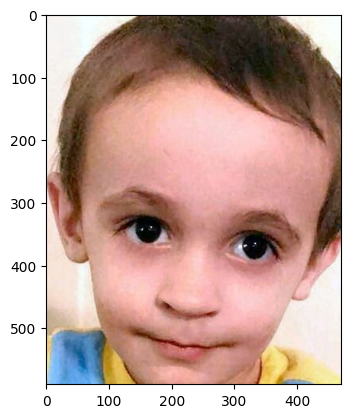

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# Path to the image file
image_path = "/kaggle/input/autism-facial-image-dataset/Facial images dataset for Autism Detection/train/autistic/0001.jpg"

# Read the image file using PIL
image = Image.open(image_path)
width, height = image.size

print("Image dimensions: {} x {}".format(width, height))
# Display the image using plt.imshow()
plt.imshow(image)
plt.show()


<h3>4. Load data</h3>

In [16]:
train_data = CustomDataset(root = root, data = "train", transformations = t)
valid_data = CustomDataset(root = root, data = "valid",transformations = t)
test_data = CustomDataset(root = root, data = "test",transformations = t)
    

In [19]:
ns=4
bs=32

In [20]:
tr_dl = DataLoader(train_data, batch_size = bs, shuffle = True, num_workers = ns) 
val_dl =DataLoader(valid_data, batch_size = bs, shuffle = False, num_workers = ns)
ts_dl=DataLoader(test_data, batch_size = 1, shuffle = False, num_workers = ns)

In [21]:
print(len(tr_dl)); print(len(val_dl)); print(len(ts_dl)); print(train_data.cls_names)

79
7
200
{'autistic': 0, 'non_autistic': 1}


<h3>5. Plot images with classes</h3>

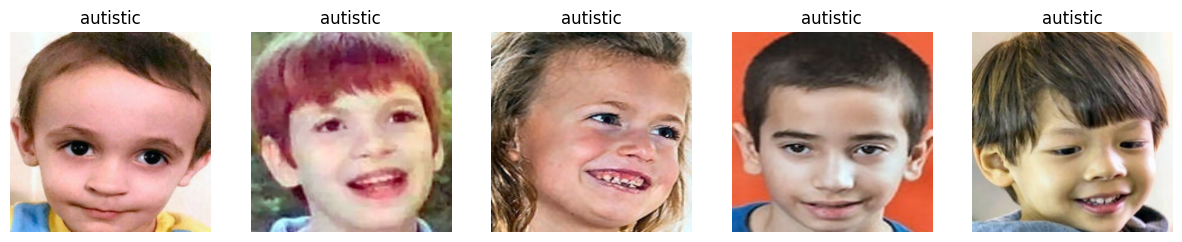

In [ ]:
def denormalize(image_tensor, mean, std):
    """Denormalize a tensor of images."""
    # Clone the tensor to avoid modifying the original tensor
    denormalized_tensor = image_tensor.clone()
    for t, m, s in zip(denormalized_tensor, mean, std):
        t.mul_(s).add_(m)  # Multiply by std and add mean
    return denormalized_tensor

def plot_images(dataset, num_images=5):
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        image, label = dataset[i]
        
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        denormalized_out = denormalize(image, mean, std)

        denormalized_out = denormalized_out.numpy()
        denormalized_out = np.transpose(denormalized_out, (1, 2, 0))
        class_name = list(dataset.cls_names.keys())[list(dataset.cls_names.values()).index(label)]
        plt.subplot(1, num_images, i+1)
        plt.imshow(denormalized_out)  
        plt.title(class_name)
        plt.axis('off')
    plt.show()

plot_images(train_data)

<h3>6. Define your model</h3>

In [23]:
class AutismNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.pretrainednet=torchvision.models.vgg16(weights=torchvision.models.VGG16_Weights.DEFAULT)
        self.pretrainednet.classifier=nn.Sequential(
            nn.Linear(in_features=25088, out_features=4096,bias=True),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(in_features=4096, out_features=1024, bias=True),
            nn.ReLU(),
            #nn.Dropout(p=0.2),
            nn.Linear(in_features=1024,out_features=2, bias=True),
            nn.Sigmoid()
        )

    def forward(self,x):
        x=self.pretrainednet(x)
        return x


In [24]:
import torch
import torchvision.models as models

# Specify the path to the locally downloaded model file
local_model_path = "C:/Users/haris/Downloads/vgg16-397923af.pth"

# Load the model from the local file
model = models.vgg16
print(model)

# Now you can use the model as usual


<function vgg16 at 0x78bc5744a290>


In [26]:

model=AutismNet()
model=model.to(device)
print(model)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


URLError: <urlopen error [Errno -3] Temporary failure in name resolution>

In [ ]:
train_loss=[]
train_acc=[]
val_loss=[]
val_acc=[]

In [ ]:
def train_one_epoch(dataloader, model,loss_fn, optimizer):
    model.train()
    track_loss=0
    num_correct=0

    for i, (imgs, labels) in enumerate(dataloader):
        imgs=imgs.to(device)
        labels=labels.to(device)
        pred=model(imgs)
        _,out=torch.max(pred,1)
        #print("out: ",out)
        #print("labels: ",labels)
        loss=loss_fn(pred,labels)
        track_loss+=loss.item()
        num_correct+=(out==labels).type(torch.float).sum().item()

        running_loss=round(track_loss/(i+(imgs.shape[0]/bs)),2)
        running_acc=round((num_correct/((i*bs+imgs.shape[0])))*100,2)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if i%100==0:
            print("Batch:", i+1, "/",len(dataloader), "Running Loss:",running_loss, "Running Accuracy:",running_acc)

    epoch_loss=running_loss
    epoch_acc=running_acc
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    return epoch_loss, epoch_acc

def eval_one_epoch(dataloader, model,loss_fn):
    model.eval()
    track_loss=0
    num_correct=0

    for i, (imgs, labels) in enumerate(dataloader):
        imgs=imgs.to(device)
        labels=labels.to(device)
        pred=model(imgs)
        _,out=torch.max(pred,1)
        #print("out: ",out)
        #print("labels: ",labels)
        loss=loss_fn(pred,labels)
        track_loss+=loss.item()
        num_correct+=(out==labels).type(torch.float).sum().item()

        running_loss=round(track_loss/(i+(imgs.shape[0]/bs)),2)
        running_acc=round((num_correct/((i*bs+imgs.shape[0])))*100,2)

        if i%100==0:
            print("Batch:", i+1, "/",len(dataloader), "Running Loss:",running_loss, "Running Accuracy:",running_acc)

    epoch_loss=running_loss
    epoch_acc=running_acc
    val_loss.append(epoch_loss)
    val_acc.append(epoch_acc)
    return epoch_loss, epoch_acc

<h3> 7. Train model</h3>
In this approach, a pretrained CNN, such as VGG16, is utilized as a feature extractor. Initially, only the newly added classifier layers on top of the pretrained model are trained on the target dataset, allowing them to learn task-specific features while keeping the pretrained weights fixed. After the classifier layers have been trained to a certain extent, the entire model, including the pretrained layers, is fine-tuned on the target dataset. 

In [ ]:
for param in model.pretrainednet.features.parameters():
    param.requires_grad=False

loss_fn=nn.CrossEntropyLoss()
lr=0.001
optimizer=torch.optim.SGD(params=model.parameters(), lr=lr)
#optimizer=torch.optim.Adam(params=model.parameters(), lr=lr)
n_epochs=40

for i in range(n_epochs):
    print("Epoch No:",i+1)
    train_epoch_loss, train_epoch_acc=train_one_epoch(tr_dl,model,loss_fn,optimizer)
    val_epoch_loss, val_epoch_acc=eval_one_epoch(val_dl,model,loss_fn)
    print("Training:", "Epoch Loss:", train_epoch_loss, "Epoch Accuracy:", train_epoch_acc)
    print("Inference:", "Epoch Loss:", val_epoch_loss, "Epoch Accuracy:", val_epoch_acc)
    print("--------------------------------------------------")

for param in model.pretrainednet.features.parameters():
    param.requires_grad=True

for i in range(n_epochs):
    print("Epoch No:",i+1)
    train_epoch_loss, train_epoch_acc=train_one_epoch(tr_dl,model,loss_fn,optimizer)
    val_epoch_loss, val_epoch_acc=eval_one_epoch(val_dl,model,loss_fn)
    print("Training:", "Epoch Loss:", train_epoch_loss, "Epoch Accuracy:", train_epoch_acc)
    print("Inference:", "Epoch Loss:", val_epoch_loss, "Epoch Accuracy:", val_epoch_acc)
    print("--------------------------------------------------")

In [ ]:
import matplotlib.pyplot as plt

def plot_metrics(train_loss, train_acc, val_loss, val_acc):
    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()


plot_metrics(train_loss, train_acc, val_loss, val_acc)


In [ ]:

# Evaluate the model on the test dataset
model.eval()
correct = 0
total = 0
all_images = []
all_original_labels = []
all_predicted_labels = []

with torch.no_grad():
    for images, labels in ts_dl:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        original_labels = [list(ts_dl.dataset.cls_names.keys())[list(ts_dl.dataset.cls_names.values()).index(label.item())] for label in labels]
        predicted_labels = [list(ts_dl.dataset.cls_names.keys())[list(ts_dl.dataset.cls_names.values()).index(pred.item())] for pred in predicted]

        # Accumulate images and labels
        all_images.extend(images.cpu().numpy())
        all_original_labels.extend(original_labels)
        all_predicted_labels.extend(predicted_labels)

# Print accuracy
print('Accuracy of the model on the test images: {:.2f} %'.format(100 * correct / total))

# Display images with labels in a grid


In [ ]:
def imshow_grid(images, original_labels, predicted_labels, max_cols=5):
    num_images = len(images)
    num_cols = min(max_cols, num_images)  # Maximum number of columns
    num_rows = int(np.ceil(num_images / num_cols))
    
    mean = np.array([0.485, 0.456, 0.406])  # Convert mean to NumPy array
    std = np.array([0.229, 0.224, 0.225])    # Convert std to NumPy array
    
    # Reshape mean and std to match the shape of images
    mean = mean.reshape((1, 3, 1, 1))
    std = std.reshape((1, 3, 1, 1))
    
    # Perform element-wise multiplication
    images = images * std + mean
    
    plt.figure(figsize=(20, 50))
    for i in range(num_images):
        image = np.transpose(images[i], (1, 2, 0))  # Transpose the image tensor
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(image)
        plt.title(f'Original: {original_labels[i]}\nPredicted: {predicted_labels[i]}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
imshow_grid(all_images, all_original_labels, all_predicted_labels)
